In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report, mean_squared_error

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [15]:
from sklearn.tree import export_graphviz

#!pip install graphviz
#import graphviz

In [22]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint as sp_randint

In [45]:
from sklearn.svm import SVC
from scipy.stats import uniform as sp_uniform

In [62]:
from sklearn.neural_network import MLPClassifier

**EXERCISE 1**

**1.A**

In [67]:
wines = pd.read_csv('data/strongdrink.txt')

In [68]:
wines.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [69]:
X = wines[['alco', 'malic', 'tot_phen', 'color_int']].values
y = wines['cultivar'].values

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

In [71]:
MultLogReg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

In [72]:
print(MultLogReg.intercept_[0:2])
print(MultLogReg.coef_[0:2,:])

[-24.02761485  22.78073088]
[[ 1.70173414 -0.26578736  1.2241009   0.02250728]
 [-1.46629727 -0.33295097  0.66355617 -0.9226817 ]]


In [73]:
y_pred=MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [74]:
wines['cultivar'].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

Classes 2 and 3 have the lowest error rates (i.e. 1 - precision, as reported above). Based on the f1-score, the model predicts class 3 best. Class 3, nonetheless, has the least number of observations.

In [75]:
print('Validation set MSE = ', mean_squared_error(y_test, y_pred))

Validation set MSE =  0.045454545454545456


**1.B**

In [76]:
N_loo = X.shape[0]
LeaveOneOut().get_n_splits(X)
MSE_vec = np.zeros(N_loo)
y_pred = np.zeros(N_loo)

for train_index, test_index in LeaveOneOut().split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    MultLogReg = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    MultLogReg.fit(X_train, y_train)
    y_pred[test_index] = MultLogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred[test_index]) ** 2
    #print('MSE for test set', test_index, ' is', MSE_vec[test_index])

In [77]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [78]:
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.09659090909090909 , test estimate MSE standard err= 0.39426250589387657


The error rates have increased for two out of three classes (namely, class 2 and 3) relative to Exercise 1.A. This underpins the concern that one should not simply rely on one draw to form conclusions about model performance.

**1.C**

In [80]:
k = 6
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)
y_pred = np.zeros_like(y)

k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    MultLogReg = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial')
    MultLogReg.fit(X_train, y_train)
    y_pred[test_index] = MultLogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred[test_index]) ** 2).mean()
    
    k_ind += 1

In [81]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        59
           2       0.90      0.90      0.90        71
           3       0.93      0.93      0.93        46

   micro avg       0.91      0.91      0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



In [82]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.12375478927203064 test estimate MSE standard err= 0.08696642841787021


**EXERCISE 2**

**2.A**

In [4]:
biden = pd.read_csv('data/biden.csv')
biden = biden.dropna()

In [5]:
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [7]:
X = biden[['female', 'age', 'educ', 'dem', 'rep']].values
y = biden['biden'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=25)

In [11]:
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

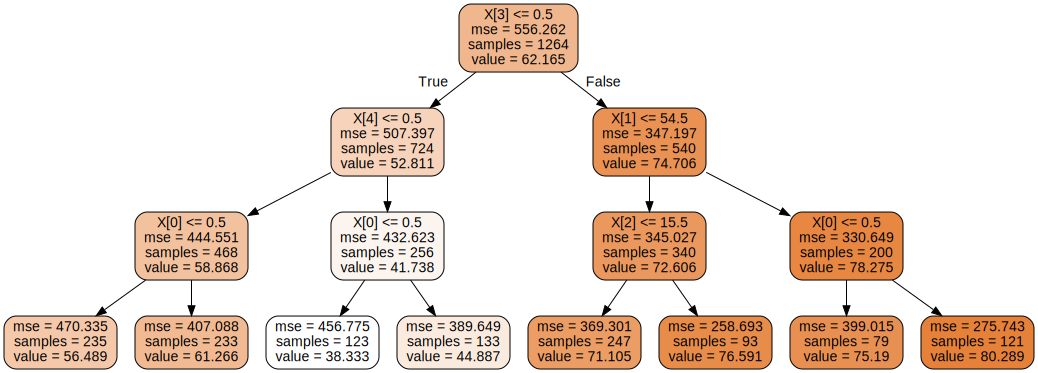

In [28]:
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    #feature_names=biden.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

In [24]:
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 396.1937146321307


**2.B**

In [31]:
param_dist1 = {'max_depth': [3, 10],
               'min_samples_split': sp_randint(2, 20),
               'min_samples_leaf': sp_randint(2, 20)}

biden_tree2 = DecisionTreeRegressor()

random_search1 = RandomizedSearchCV(biden_tree2, param_distributions=param_dist1, n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search1.fit(X, y)
print('Best Estimator =', random_search1.best_estimator_)
print('Best Parameters =', random_search1.best_params_)
print('Best Score =', -random_search1.best_score_)

Best Estimator = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=14, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')
Best Parameters = {'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 14}
Best Score = 401.6903602232667


**2.C**

In [33]:
param_dist2 = { 'n_estimators': [10, 200],
                'max_depth': [3, 10],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 5)}

biden_forest = RandomForestRegressor(bootstrap=True,oob_score=True, random_state=25)

random_search2 = RandomizedSearchCV(biden_forest, param_distributions=param_dist2, n_iter=100, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search2.fit(X, y)
print('Best Estimator = ', random_search2.best_estimator_)
print('Best Parameters = ', random_search2.best_params_)
print('Best Score =', -random_search2.best_score_)

Best Estimator =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=17,
           min_samples_split=13, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=True, random_state=25,
           verbose=0, warm_start=False)
Best Parameters =  {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 17, 'min_samples_split': 13, 'n_estimators': 10}
Best Score = 397.0681090117028


C:\Users\woute\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


**EXERCISE 3**

**3.A**

In [34]:
autos = pd.read_csv('data/Auto.csv', na_values=['?'])
autos = autos.dropna()

In [35]:
med = autos['mpg'].median()
autos['mpg_high'] = (autos['mpg'] >= med).astype(int)

autos['const'] = 1

autos['orgn1'] = (autos['origin'] == 1).astype(int)
autos['orgn2'] = (autos['origin'] == 2).astype(int)

In [36]:
autos.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,const,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,1,0


In [37]:
X = autos[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'orgn1', 'orgn2']].values
y = autos['mpg_high'].values

In [38]:
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=25)
kf.get_n_splits(X)

MSE_vec_kf = np.zeros(k)
MSE_vec_kf_high = np.zeros(k)
MSE_vec_kf_low = np.zeros(k)
y_pred = np.zeros_like(y)

k_ind = int(0)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    LogReg = LogisticRegression(solver='liblinear')
    LogReg.fit(X_train, y_train)
    
    y_pred[test_index] = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred[test_index]) ** 2).mean()
    
    MSE_vec_kf_high[k_ind] = sum((y_test != y_pred[test_index]) * (y_test == 0)) / sum(y_test == 0)
    MSE_vec_kf_low[k_ind] = sum((y_test != y_pred[test_index]) * (y_test == 1)) / sum(y_test == 1)
    
    k_ind += 1

In [39]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       196
           1       0.89      0.92      0.90       196

   micro avg       0.90      0.90      0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



In [40]:
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.09693877551020408 test estimate MSE standard err= 0.027475330648645428


In [41]:
MSE_kf_high = MSE_vec_kf_high.mean()
MSE_kf_high_std = MSE_vec_kf_high.std()
print('test estimate MSE k-fold (high)=', MSE_kf_high,
      'test estimate MSE standard err (high)=', MSE_kf_high_std)

MSE_kf_low = MSE_vec_kf_low.mean()
MSE_kf_low_std = MSE_vec_kf_low.std()
print('test estimate MSE k-fold (low)=', MSE_kf_low,
      'test estimate MSE standard err (low)=', MSE_kf_low_std)

test estimate MSE k-fold (high)= 0.11364706285146922 test estimate MSE standard err (high)= 0.01617468606029206
test estimate MSE k-fold (low)= 0.07941477339674582 test estimate MSE standard err (low)= 0.0395630343839898


**3.B**

In [43]:
param_dist3 = { 'n_estimators': [10, 200],
                'max_depth': [3, 8],
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 8)}

mpg_forest = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=25)

random_search3 = RandomizedSearchCV(mpg_forest, param_distributions=param_dist3, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
random_search3.fit(X, y)

C:\Users\woute\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\woute\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=25, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 200], 'max_depth': [3, 8], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210A4112BA8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210A41121D0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210A4112D68>},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_

In [44]:
print('Best Estimator = ', random_search3.best_estimator_)
print('Best Parameters = ', random_search3.best_params_)
print('Best Score =', -random_search3.best_score_)

Best Estimator =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=True, random_state=25, verbose=0, warm_start=False)
Best Parameters =  {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 10}
Best Score = 0.08928571428571429


**3.C**

In [46]:
param_dist4 = { 'C': sp_uniform(loc=0.2, scale=4.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}

mpg_SVM = SVC(kernel='rbf')

random_search4 = RandomizedSearchCV(mpg_SVM, param_distributions=param_dist4, n_iter=100, n_jobs=-1, cv=4, random_state=25, scoring='neg_mean_squared_error')
random_search4.fit(X, y)
print('Best Estimator = ', random_search4.best_estimator_)
print('Best Parameters = ', random_search4.best_params_)
print('Best Score =', -random_search4.best_score_)

Best Estimator =  SVC(C=1.8094629152568114, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=False,
  tol=0.001, verbose=False)
Best Parameters =  {'C': 1.8094629152568114, 'gamma': 'scale', 'shrinking': False}
Best Score = 0.11479591836734694


**3.D**

The random forest approach results in the lowest MSE, hence it is the best model to predict "mpg_high" given the available data.

**EXERCISE 4**

**4.A**

In [47]:
wines = pd.read_csv('data/strongdrink.txt')
X = wines[['alco', 'malic', 'tot_phen', 'color_int']].values
y = wines['cultivar'].values

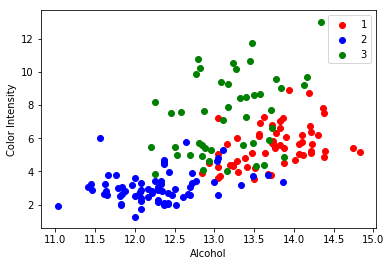

In [50]:
colors = {1:'red', 2:'blue', 3:'green'}
for i in range(1,4):
    df = wines[wines['cultivar'] == i]
    plt.scatter(df['alco'], df['color_int'], c=colors[i], label=i)

plt.xlabel("Alcohol") 
plt.ylabel("Color Intensity")
plt.legend()
plt.show()

**4.B**

In [59]:
param_dist1 = {'penalty': ['l1', 'l2'],
               'C': sp_uniform(0.1, 10.0)}

MultLogReg = LogisticRegression(solver='saga', multi_class='multinomial')
random_search1 = RandomizedSearchCV(MultLogReg, param_distributions=param_dist1, n_iter=200, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search1.fit(X, y)

print('Best Parameters = ', random_search1.best_params_)
print('Best Score =', -random_search1.best_score_)

Best Parameters =  {'C': 1.9591123209017924, 'penalty': 'l1'}
Best Score = 0.17045454545454544


C:\Users\woute\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\woute\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


**4.C**

In [60]:
param_dist2 = { 'n_estimators': sp_randint(10, 200),
                'max_depth': sp_randint(2, 4),
                'min_samples_split': sp_randint(2, 20),
                'min_samples_leaf': sp_randint(2, 20),
                'max_features': sp_randint(1, 4)}

Forest = RandomForestClassifier(bootstrap=True, oob_score=True)
random_search2 = RandomizedSearchCV(Forest, param_distributions=param_dist2, n_iter=200, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search2.fit(X, y)

print('Best Parameters = ', random_search2.best_params_)
print('Best Score =', -random_search2.best_score_)

C:\Users\woute\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters =  {'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 139}
Best Score = 0.13068181818181818


**4.D**

In [61]:
param_dist3 = { 'C': sp_uniform(loc=0.1, scale=10.0),
                'gamma': ['scale', 'auto'],
                'shrinking': [True, False]}

SVC_wines = SVC(kernel='rbf')
random_search3 = RandomizedSearchCV(SVC_wines, param_distributions=param_dist3, n_iter=200, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search3.fit(X, y)

print('Best Parameters = ', random_search3.best_params_)
print('Best Score =', -random_search3.best_score_)

Best Parameters =  {'C': 3.3605112613782553, 'gamma': 'scale', 'shrinking': True}
Best Score = 0.14772727272727273


C:\Users\woute\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**4.E**

In [64]:
param_dist4 = {'hidden_layer_sizes': sp_randint(1, 100),
                'activation': ['logistic', 'relu'],
                'alpha': sp_uniform(0.1, 10.0)}

Neural_Net = MLPClassifier(solver='lbfgs')
random_search4 = RandomizedSearchCV(Neural_Net, param_distributions=param_dist4, n_iter=200, n_jobs=-1, cv=5, random_state=25, scoring='neg_mean_squared_error')
random_search4.fit(X, y)

print('Best Parameters = ', random_search4.best_params_)
print('Best Score =', -random_search4.best_score_)

C:\Users\woute\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Parameters =  {'activation': 'relu', 'alpha': 0.7965389843643799, 'hidden_layer_sizes': 91}
Best Score = 0.08522727272727272


**4.F**

Using the neural net results in the best score (i.e. lowest MSE), hence it is the best model to predict the respective "cultivar" given the available data.